# METROID - Morphological Equal-Area Technique for Regions of Interest Denoising

**main function: metroid(** *video, fr, mask, n_ROIs_out=16, n_ROIs_in=16* **)**

Return ROIs masks, means from ROIs masks and time.

Divide cell mask into two major regions (inner and outter region), then divide these regions into smaller regions of interest (ROIs) with similar area following cell shape. The number of ROIs in each major region can be adjusted by *n_ROIs_out* and *n_ROIs_in* arguments. Also, get ROIs means over time from video.

**Parameters:**  
- **video: array**
    - (F x M x N) 16-bit gray image stack, where F are frames, M are lines and N are columns.
- **fr: int**
    - video frame rate (in frames per second).
- **mask: boolean array**
    - (M x N) boolean array. Must match video dimensions.
- **n_ROIs_out: int, optional**
    - number of ROIs in the outter region.
- **n_ROIs_in: int, optional**
    - number of ROIs in the inner region.
 
**Returns:**  
- **ROIs: boolean array**
    - (R x M x N) image stack, where R are ROI numbers (R = n_ROIs_in + n_ROIs_out), M are lines and N are columns.
- **ROIs_means: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **time: array**
    - (F,) array, where F are time points.


In [1]:
testing = (__name__ == "__main__")
if testing:
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os

    metroidpath = os.path.abspath('')
    if metroidpath not in sys.path:
        sys.path.append(metroidpath)
    items = os.listdir(metroidpath)
    if 'MES.py' not in items:
        ! jupyter nbconvert --to 'python' MES.ipynb
    if 'Remove_Photobleaching.py' not in items:
        ! jupyter nbconvert --to 'python' Remove_Photobleaching.ipynb
    if 'BSSD.py' not in items:
        ! jupyter nbconvert --to 'python' BSSD.ipynb
    import MES as mes
    import Remove_Photobleaching as rpb
    import BSSD as bssd


# metroidpath = 'C:\\Users\\Marcelo\\Documents\\ia898new\\ROI analyzer\\Profluo (default regions)\\METROID'
# if metroidpath not in sys.path:
#     sys.path.append(metroidpath)


[NbConvertApp] Converting notebook MES.ipynb to python
[NbConvertApp] Writing 50297 bytes to MES.py


## Mandatory parameters:

In [2]:
if testing:
    fpath = 'Data\\Cell1\\video_EP'
    # fr_list = [55.78, 55.78, 55.78, 55.67] #Cell2
    # fr_list = [71.29, 71.29, 71.29, 71.15] #Cell1
    fr_list = [71.29]
    transitory=False

## Optional parameters:

In [3]:
if testing:
    t_sig_onset = 2.5
    t_sig_end = None
    method = 'wPCA'
    n_comp=2
    wavelet = 'Haar'
    autoselect='auto'

In [4]:
def metroid(folder,FR,transitory,t_sig_onset=None,t_sig_end=None,method='wPCA',n_comp=2,wavelet='Haar',autoselect='auto'):
    import numpy as np
    import MES as mes
    import Remove_Photobleaching as rpb
    import BSSD as bssd
    if type(FR) is not list:
        FR = [FR]
    video_list = get_img_stacks(folder)
    mask_list = load_masks(video_list, folder)

#     print('len mask list',len(mask_list))
    while(len(video_list)>len(mask_list)):
        mask_list.append(mask_list[0])
    
#     from ipynb.fs.full.MES import mes
    ROIs_means_list = []
    for video,fr,mask in zip(video_list,FR,mask_list):
#         print('LAK')
        ROIs_masks, label_ROIs, ROIs_means, time  = mes.segment(video, fr, mask)
        ROIs_means_list.append(ROIs_means)
    if len(video_list)>1:
#         print(len(ROIs_means_list))
        ROIs_means = np.mean(ROIs_means_list,axis=0)
#         print(ROIs_means.shape)
        FR = np.mean(FR)
        video = video_list[-1]
        mask = mask_list[-1]
#         from ipynb.fs.full.MES import build_time_vector
        time = mes.build_time_vector(fr,video.shape)
    
#     print(video.shape,time.shape,mask.shape,ROIs_means.shape)
#     from ipynb.fs.full.Remove_photobleaching import photob_remove    
    ROIs_means_corrected, corrections, inactive_msk,t_sig_onset  = rpb.photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end)
#     print(t_sig_onset)
    if transitory==None:
        return(ROIs_masks,label_ROIs,None,time,ROIs_means,ROIs_means_corrected,corrections,mask_list,None,None)
#     from ipynb.fs.full.BSSD import BSSD
    ROIs_filtered,sources,selected_source_idx = bssd.denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method,n_comp,wavelet,autoselect)
    return(ROIs_masks,label_ROIs,ROIs_filtered,time,ROIs_means,ROIs_means_corrected,corrections,mask_list,sources,selected_source_idx)

In [5]:
def get_img_stacks(folder):
    '''Gets image stacks in .tif format
       Stacks order should be defined by the last character in each name'''
    from skimage import io
    import os
    items = os.listdir(folder)
    stacks_names = []
    fext='.tif'
    for fname in items:
        if fname.endswith(fext):
            stacks_names.append(fname)
    if stacks_names==[]:
        print("No .tif files found in ", folder)
        return
    else:
        def last_character(name):
            return name[-5]
        stacks_names.sort(key=last_character)

        video_list = []
        for fname in stacks_names:
            fullpath = folder + '\\' + fname
            f = io.imread(fullpath)
            if len(f.shape)>2: #Get only videos, single images are not included
                video_list.append(f)
        return(video_list)

In [6]:
def load_masks(video_list,folder=None):
    '''Load cell masks from dir
       Cell masks should be binary images with the same shape (lin, col) as the videos
       If there are no cell masks, this function produces an approximated cell mask for each video'''
    import numpy as np
    from skimage import io
    import os
    #If masks are not provided, generate masks by adding first images until any pixel saturation
    if folder==None:
        from skimage.filters import threshold_otsu, threshold_local
        from skimage.morphology import remove_small_objects
        from skimage.segmentation import clear_border
        import scipy.ndimage as sm
        n_sum_til_saturation = []
        for v in video_list:
            f0mean = np.mean(v[0])
            temp = (2**16)//f0mean
            n_sum_til_saturation.append(temp.astype(int))
            
        
        f_satlist = []
        b_satlist = []
        for n,v in zip(n_sum_til_saturation,video_list):
            f_sat = np.zeros_like(v[0],dtype='uint32')
            b_sat = np.zeros_like(v[0],dtype='bool')
            
            #adds first images pixel to pixel
            for j in range(n-1):
                f_sat = np.add(f_sat,v[j])
                
            sat_values = f_sat>65535
            f_sat[sat_values] = 65535
            
            
            f_sat = sm.gaussian_filter(f_sat,sigma=2)

            f_satlist.append(f_sat.astype('uint16'))
            block_size = 99
            thresh = threshold_local(f_sat, block_size, offset=0)
            b_sat = f_sat > thresh

            b_sat = sm.binary_closing(b_sat,iterations=1)
            b_sat = sm.binary_fill_holes(b_sat)
            b_sat = remove_small_objects(b_sat,500)

            
            # removes artifacts connected to image border
            b_sat = clear_border(b_sat)
            
            b_satlist.append(b_sat.astype(bool))
    else:
        items = os.listdir(folder)
        stacks_names = []
        fext='.tif'
        for fname in items:
            if fname.endswith(fext):
                stacks_names.append(fname)
        # checks whether there are .tif files in directory
        if stacks_names==[]:
            print("No .tif files found in ", folder)
            return
        else:
            def last_character(name):
                return name[-5]
            stacks_names.sort(key=last_character)
            b_satlist = []
            for fname in stacks_names:
                fullpath = folder + '\\' + fname
                b = io.imread(fullpath)
                if len(b.shape)<3:
                    b_satlist.append(b.astype(bool)) 
    return(b_satlist)

In [7]:
if testing:
    ROIs_masks,label_ROIs,ROIs_filtered,time,ROIs_means,ROIs_means_corrected,corrections,mask_list,sources,selected_source_idx = metroid(fpath,fr_list,transitory,t_sig_onset,t_sig_end,method,n_comp,wavelet,autoselect)

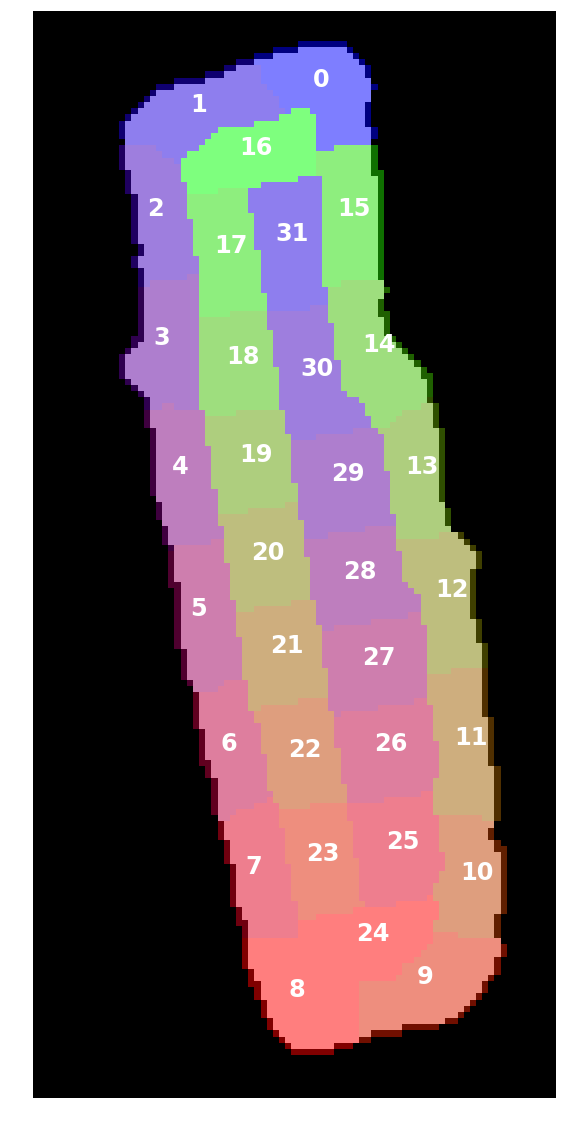

In [8]:
if testing:
    segments = ROIs_masks[0:ROIs_masks.shape[0]//2,:,:]
    slices = ROIs_masks[ROIs_masks.shape[0]//2:,:,:]
    mask = mask_list[0]
    def get_centroid(msk):
        '''Get central point of shape'''
        from skimage.measure import label, regionprops
        label_img = label(msk)
        regions = regionprops(label_img)
        for props in regions:
            y0, x0 = props.centroid
        return(x0, y0)
    fig, ax = plt.subplots(figsize=[15,20],nrows=1, ncols=1)
    #     row=0
    #     col=0
    #     for s,ss,m in zip(segments_list,slices_list,msklist):
    segment_rgb = np.zeros((segments.shape[1],slices.shape[2],3))
    nregions = segments.shape[0]


    cent_coord = np.zeros((nregions,2))
    cent_coord2 = np.zeros((nregions,2))
    for j in range(nregions):
        r = j/(nregions//2)
        b = 1 - r
        g = 0
        if(j>nregions//2):
            g = (j-nregions//2)/(nregions//2)
            b = 0
            r = 1 - g  


        segment_rgb[:,:,0] = segment_rgb[:,:,0] + r*segments[j,:,:] + r*slices[j,:,:]
        segment_rgb[:,:,1] = segment_rgb[:,:,1] + g*segments[j,:,:] + b*slices[j,:,:]
        segment_rgb[:,:,2] = segment_rgb[:,:,2] + b*segments[j,:,:] + g*slices[j,:,:]
        cent_coord[j,:] = np.rint(get_centroid(segments[j,:,:]))
        cent_coord2[j,:] = np.rint(get_centroid(slices[j,:,:]))
    ax.imshow(segment_rgb)
    for j in range(nregions):
        k = j
        ax.annotate(k,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
    for j in range(nregions):
        k = j+nregions
        ax.annotate(k,(cent_coord2[j,0]-2,cent_coord2[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
    ax.axis('off')
    #     pathtemp = 'C:/Users/Marcelo/Desktop/Artigo modelo filtragem/graph data to plot/'
    #     plt.savefig(pathtemp+'graph_regions.tiff',bbox_inches='tight',pad_inches=0,dpi=600)
    ax.imshow(mask,alpha=0.5,cmap='gray')
    #     col+=1
    #         if col>1:
    #             col=0
    #             row+=1

In [9]:
if testing:
    print(corrections)

{'lin': array([ 0,  5,  6, 10, 20, 22, 23, 25, 27], dtype=int64), 'exp': array([24], dtype=int64), 'exp&lin': array([ 1,  2,  3,  4,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21,
       26, 28, 29, 30, 31], dtype=int64)}


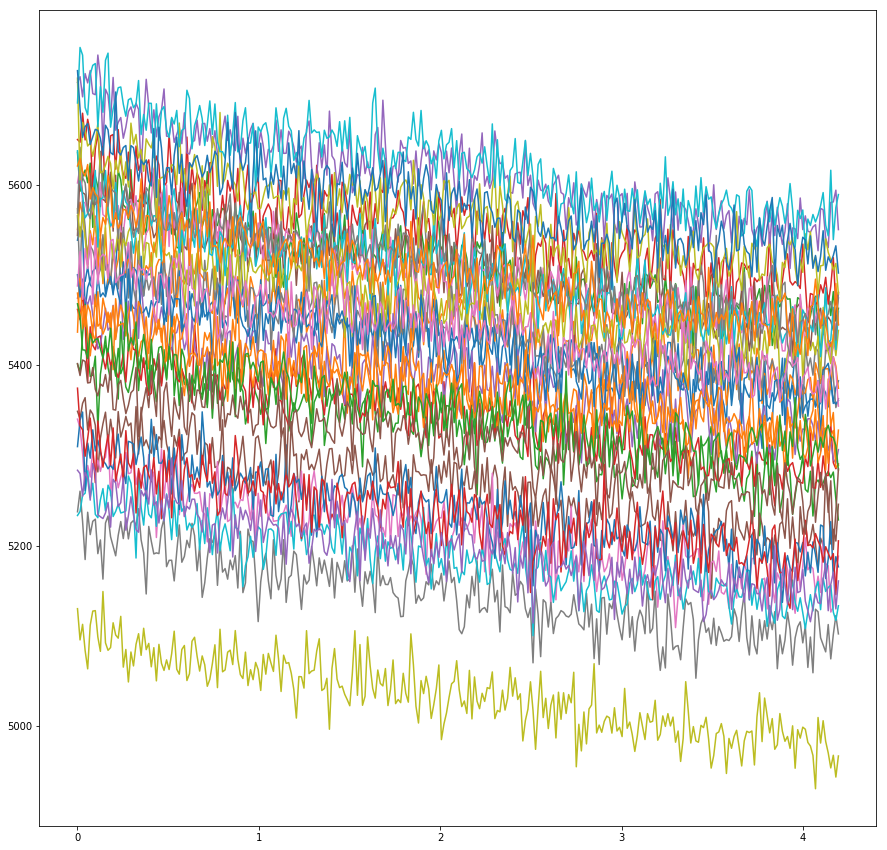

In [10]:
if testing:
    plt.figure(figsize=[15,15])
    plt.plot(time, ROIs_means)

[ 1.26052774e-12  4.29962832e-01 -1.39773853e-01  4.01489629e-01
  1.76755039e-02  1.04246176e-12  2.69657201e-12 -6.86392439e-02
 -3.25194485e-02 -1.91891801e-01  1.79239599e-12 -4.36587835e-01
  2.65712122e-01 -4.82689298e-02 -1.69185037e-02  1.74212149e-01
 -2.64982340e-01  4.80243205e-01 -5.62363662e-01 -8.21450060e-02
  1.68070366e-12 -2.20069623e-01  8.08439735e-13 -7.44615545e-13
  2.17784744e-01 -6.70153991e-13 -2.18724470e-02  9.52044162e-13
  3.03333787e-02  1.80617253e-01  3.09521852e-01 -4.30353096e-02]


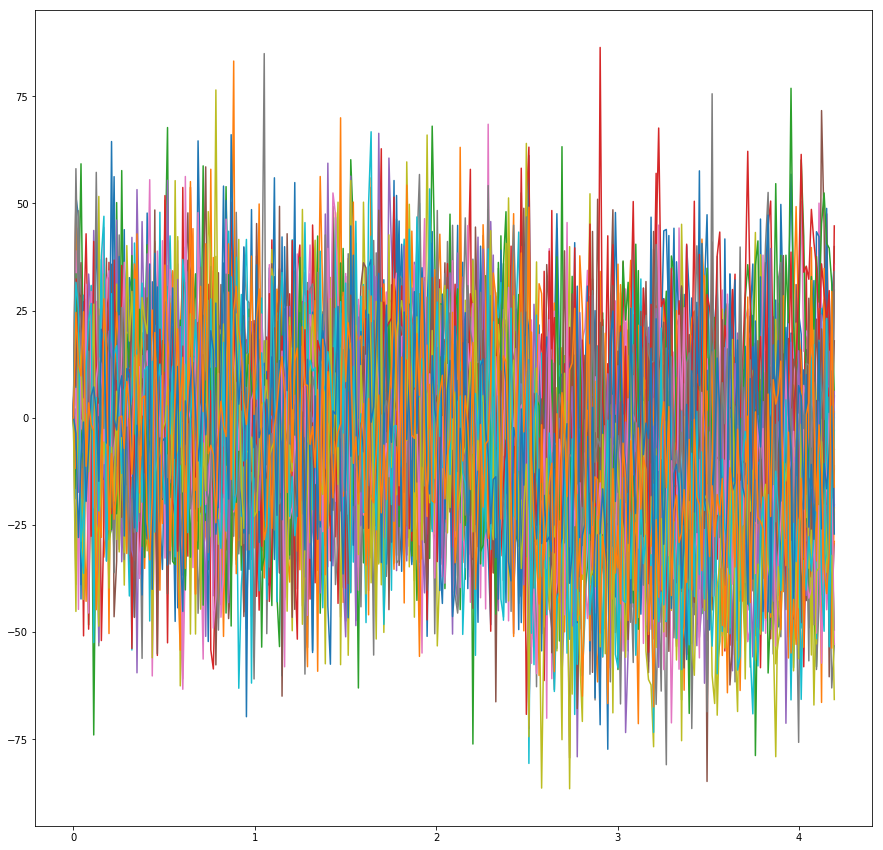

In [11]:
if testing:
    plt.figure(figsize=[15,15])
    plt.plot(time, ROIs_means_corrected)
    print(ROIs_means_corrected[0,:])

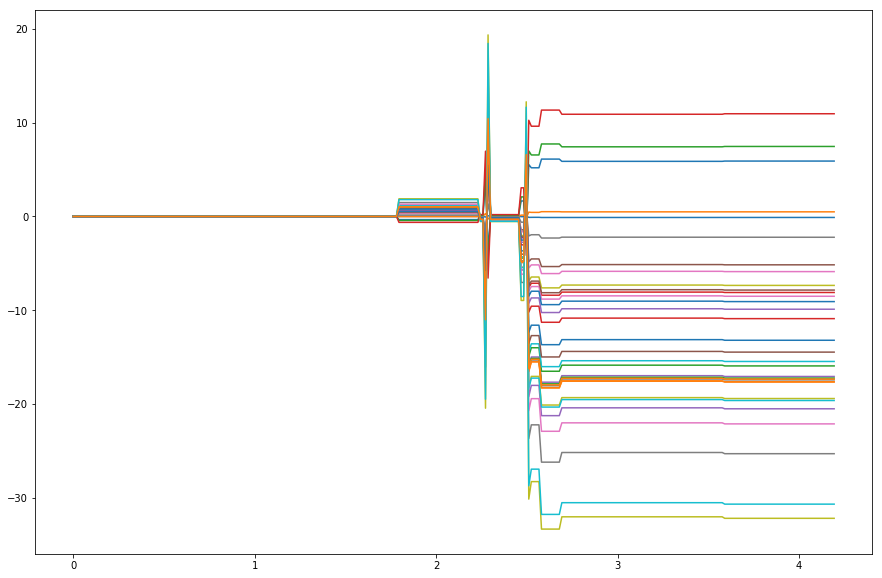

In [12]:
if testing:
    plt.figure(figsize=[15,10])
    plt.plot(time, ROIs_filtered[:,:])